In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Définition des équations différentielles du modèle SIR


def deriv(t, y, N, beta, gamma, delta):
    """
        N : population totale
        beta : taux de contamination
        gamma :taux de guérison, 
        delta : taux de mortalité
    """

    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dIdt, dRdt, dDdt

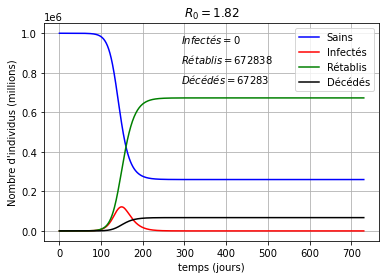

Nombre maximum de personnes infectées: 121713
Conservation de la population: 6.111804395914078e-10


In [18]:
def sird(N=1000000, duree=730, beta=0.2, gamma=0.1, delta=0.01):
    # Nombre initial d'individus infectés, rétablis et décédés, le reste est sain
    I0, R0, D0 = 1, 0, 0
    S0 = N - I0 - R0 - D0
    # Vecteur des conditions initiales
    y0 = S0, I0, R0, D0
    # Vecteur des temps 2 ans
    t = np.linspace(0, duree, duree)
    # Résolution des équations différentielles du modèle SIR
    sol = solve_ivp(deriv, [0, duree], y0, t_eval=t,
                    args=(N, beta, gamma, delta))
    S, I, R, D = sol.y
    # Traçage des résultats
    plt.plot(t, S, 'b', label='Sains')
    plt.plot(t, I, 'r', label='Infectés')
    plt.plot(t, R, 'g', label='Rétablis')
    plt.plot(t, D, 'k', label='Décédés')
    plt.xlabel('temps (jours)')
    plt.ylabel('Nombre d\'individus (millions)')
    # calcul du R_0
    R_0 = beta*S0/(N*(gamma + delta))
    plt.title(r'$R_0=%.2f$' % (R_0, ))  # affiche le R_0
    # affiche les valeurs finales
    plt.text(0.4*duree, 0.95*N, r'$Infectés=%.1i$' % (I[-1],))
    plt.text(0.4*duree, 0.85*N, r'$Rétablis=%.1i$' % (R[-1],))
    plt.text(0.4*duree, 0.75*N, r'$Décédés=%.1i$' % (D[-1],))
    plt.legend()
    plt.grid(True)
    plt.savefig('sir.png')
    plt.show()
    print('Nombre maximum de personnes infectées:', int(np.max(I)))
    # verifie que S+I+R+D = N au cours du temps
    print('Conservation de la population:', np.max(np.abs(N-S-I-R-D)))

    return


sird()

On définit $R_0 = \dfrac{\beta S_0}{N(\gamma + \delta)}.$


In [3]:
# pour jouer facilement avec les paramètres
from ipywidgets import interact
interact(sird, duree=(30,720,30), beta=(0.1, 0.4, 0.01), gamma=(
    0.1, 0.5, 0.01), delta=(0.01, 0.2, 0.01))

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


<function __main__.sird(N=1000000, duree=730, beta=0.2, gamma=0.1, delta=0.01)>

Lorsqu'on augmente le paramètre $\delta$ on constate que l'épidémie s'arrête! Le virus est pourtant beaucoup plus virulent. Mais les personnes infectées décèdent trop vite et n'ont pas le temps de contaminer d'autres personnes.

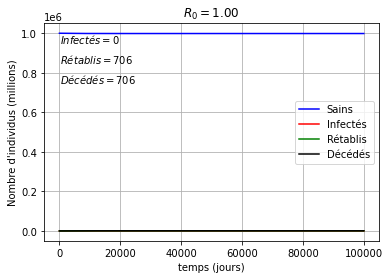

Nombre maximum de personnes infectées: 1
Conservation de la population: 2.710294211283326e-10


In [6]:
sird(N=1000000,duree=100000, beta=0.2, gamma=0.1, delta=0.1)

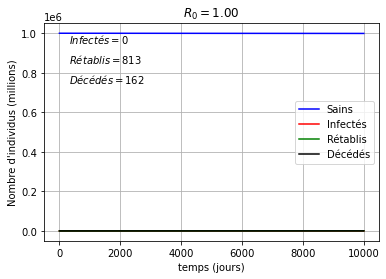

Nombre maximum de personnes infectées: 1
Conservation de la population: 1.2170175978098996e-10


In [8]:
sird(N=1000000,duree=10000, beta=0.12, gamma=0.1, delta=0.02)

Lorsque $R_0 = 1$ on retrouve le même phénomène, l'épidémie ne se déclenche pas. Le nombre d'infectés n'augmente pas suffisamment.

***On remarque aussi que le ratio limite Rétablis/Décédés vaut approximativement $\gamma/\delta$.*** On peut établir ce fait, voir les compléments.

### Compléments facultatifs: régime asymptotique

On intègre $R(t) = \gamma \int_0^t I(s) ds$, 
$D(t) = \delta \int_0^t I(s) ds$ et 
$$S(t) = S_0 \exp{-\frac{\beta}{N} \int_0^t I(s) ds }.$$

Quand $t\to +\infty$ $R(t) \to \gamma \int_0^\infty I(s) ds.$
Quand $t\to +\infty$ $D(t) \to \delta \int_0^\infty I(s) ds.$

Posons $I^\star = \int_0^\infty I(s) ds$ intégrale convergente sinon $R(t)$ et $D(t)$ ne sont pas bornées.

On trouve donc les valeurs limites
$ S_{lim} = S_0 \exp{-\frac{\beta}{N} I^\star},$
$R_{lim} = \gamma I^\star,$
$D_{lim} = \delta I^\star,$
tandis que $I_{lim} = 0$ puisque l'équilibre est atteint.
On démontre ainsi que les valeurs limites $R_{lim}/ D_{lim} = \gamma/\delta$ ***respectent les proportions entre $\gamma$ et $\delta$***, ce qu'on voit sur les simulations.

On peut calculer directement $I^\star$ en résolvant l'équation non linéaire 
$$S_{lim} + R_{lim} + D_{lim} = S_0 \exp{(-\frac{\beta}{N} I^\star)}+(\gamma + \delta) I^\star = N
$$ 

In [9]:
import numpy as np

from scipy.optimize import fsolve

N = 1000000
beta = 0.2
gamma = 0.1
delta = 0.01


def func(x, args=(N, beta, gamma, delta)):

    return (N-1)*np.exp(-beta*x/N) + (gamma + delta)*x - N

#il faut chercher une racine au voisinage de +l'infini
#car la fonction s'annule deux fois, une fois pour une valeur négative
# et une fois pour une valeur positive. Pour que le solveur retourne
#cette valeur, il faut l'initialiser avec une grande valeur
root = fsolve(func, 10*N)

In [10]:
root

array([6719997.97578123])

### On retrouve les populations limites!

In [11]:
# populations limites guéris, décédés
Rlim= root[0]*gamma
Dlim = root[0]*delta
print(f'population limite guéris = {Rlim :.1f}.')
print(f'population limite décédés = {Dlim :.1f}.')

population limite guéris = 671999.8.
population limite décédés = 67200.0.


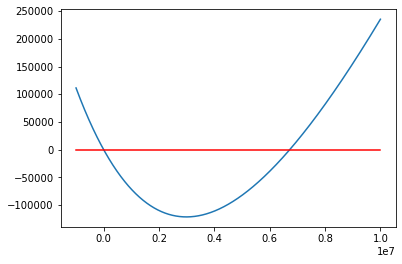

In [12]:
#tracé de la fonction
x=np.linspace(-N,10*N,1000)
plt.plot(x,func(x,args=(N,beta,gamma,delta) ))
plt.plot(x,x*0,'r')
plt.show()

Attention on est tenté de linéariser l'équation non linéaire.
Si on le fait, on obtient des résultats aberrants, car on sélectionne la racine négative de la fonction. En effet $\exp{(-\frac{\beta}{N} I^\star)} \approx 1 -\frac{\beta}{N} I^\star$ et l'équation non linéaire donne
$$(N-1)( 1 -\frac{\beta}{N} I^\star) + (\gamma + \delta) I^\star =N$$
cela donne $$I^\star= \frac{1}{(\gamma+ \delta - \beta (N-1)/N)} = 
\frac{1}{(\gamma+ \delta)(1 - R_0)}$$
qui est négative. Cela signifie que $\beta I^\star$ n'est pas négligeable devant $N$. 

In [13]:
Istar= 1/(gamma+ delta - (N-1)*beta/N)
print(f'On obtient la valeur aberrante Istar ={Istar:.3f}.')

On obtient la valeur aberrante Istar =-11.111.
